In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


In [21]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-recognition


In [22]:
def creat_my_data(dataset_path):
  X = []
  y = []
  for cls in os.listdir(dataset_path):
    images_paths = os.listdir(f'{dataset_path}/{cls}')
    images_paths = [f'{dataset_path}/{cls}/{img}' for img in images_paths]
    labels = [cls] * len(images_paths)
    X.extend(images_paths)
    y.extend(labels)
  return X, y

In [29]:
x,y = creat_my_data("/kaggle/input/flowers-recognition/flowers")

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle=True, random_state=42)

In [31]:
train_df = pd.DataFrame({'image_path': x_train, 'label': y_train})
test_df = pd.DataFrame({'image_path': x_test, 'label': y_test})

In [32]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
val_datagen=ImageDataGenerator(
    rescale=1./255,
)

In [33]:
train = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Load validation images
val = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


# Model

In [49]:
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Fully connected
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer for 5 classes
model.add(Dense(5, activation='softmax'))

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [57]:
history=model.fit(train, epochs=25, validation_data=val,callbacks=[early_stopping])

Epoch 1/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - accuracy: 0.7803 - loss: 1.9568 - val_accuracy: 0.7211 - val_loss: 2.2142
Epoch 2/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.7434 - loss: 1.9867 - val_accuracy: 0.7523 - val_loss: 1.9563
Epoch 3/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.7508 - loss: 1.9367 - val_accuracy: 0.7627 - val_loss: 1.8938
Epoch 4/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.7568 - loss: 1.8488 - val_accuracy: 0.7269 - val_loss: 2.0484
Epoch 5/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 0.7740 - loss: 1.8227 - val_accuracy: 0.7593 - val_loss: 1.8401
Epoch 6/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.7722 - loss: 1.7697 - val_accuracy: 0.6910 - val_loss: 2.1213
Epoch 7/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.7670 - loss: 1.8025 - val_accuracy: 0.7477 - val_loss: 1.8422
Epoch 8/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.7792 - loss: 1

In [58]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.2f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.2f}")

Final Training Accuracy: 0.82
Final Validation Accuracy: 0.78


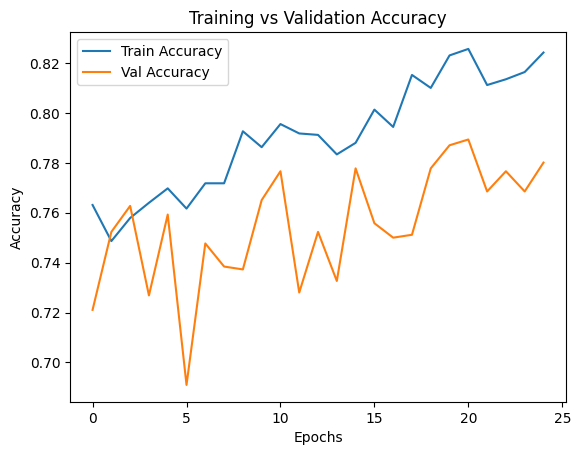

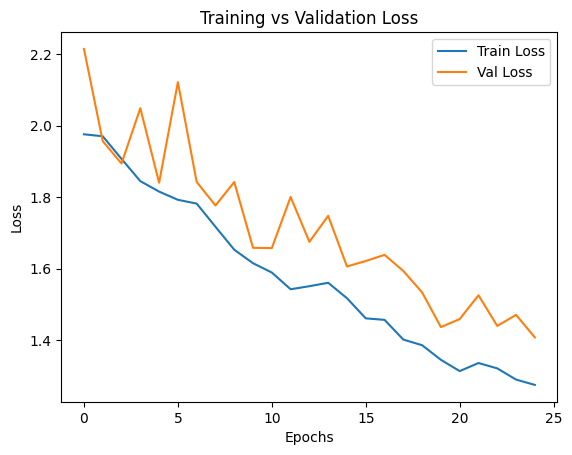

In [59]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()

In [60]:
model.save('flowers.keras')